In [2]:
!pip install tensorflow numpy streamlit   
# هنا بنزل ال tensorflow ودي مسؤولة عن الديب ليرنينج وموديلات AI **
# numpy بتتعامل مع الارايز والعمليات الحسابية
# streamlit بتخليني ابني صفحة ويب بالموديل اللي عملته

In [108]:
import os #التعامل مع الملفات
import numpy as np #التعامل مع المصفوفات والعمليات الرياضية.
import matplotlib.pyplot as plt # لعرض صور، منحنيات الأداء (loss, accuracy).
import seaborn as sns #  لرسم الرسومات الإحصائية مثل مصفوفة الارتباك (confusion matrix) بشكل جميل.
import tensorflow as tf  # تستورد TensorFlow بالكامل، وlayers لتسهيل استدعاء طبقات الشبكة.
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing import image
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator #load_img: لتحميل صورة مفردة. ImageDataGenerator: لتوليد صور أثناء التدريب مع عمليات augmentation (مثل تدوير، قص، تغيير الإضاءة...).
from tensorflow.keras.models import Sequential, load_model #Sequential: لإنشاء نموذج متسلسل (طبقة فوق طبقة). load_model: لتحميل نموذج تم تدريبه مسبقاً.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten #Conv2D:تلتقط السمات من الصور. MaxPooling2D:لتقليل حجم البيانات (downsampling). Flatten:لتحويل الأبعاد لمصفوفة واحدة. Dense:الطبقات الكثيفة (Fully Connected). Dropout:لمنع overfitting.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau #EarlyStopping: يوقف التدريب تلقائياً إذا لم يتحسن الأداء ModelCheckpoint: يحفظ أفضل نسخة من النموذج تلقائياً.
from sklearn.metrics import confusion_matrix, classification_report #confusion_matrix: لتقييم عدد التوقعات الصحيحة/الخطأ. classification_report: يعطي الدقة،
from sklearn.utils.class_weight import compute_class_weight

In [106]:
count = 0 
dirs = os.listdir('flowers/')
for dir in dirs:
    files = list(os.listdir('flowers/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

daisy Folder has 763 Images
dandelion Folder has 1052 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
tulip Folder has 984 Images
Images Folder has 4316 Images


In [112]:
# تحميل البيانات Data Analysis
base_dir = 'flowers/'
img_size = 512
batch = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)

flower_names = train_ds.class_names
print(flower_names)

Found 4316 files belonging to 5 classes.
Using 3453 files for training.
Found 4316 files belonging to 5 classes.
Using 863 files for validation.
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


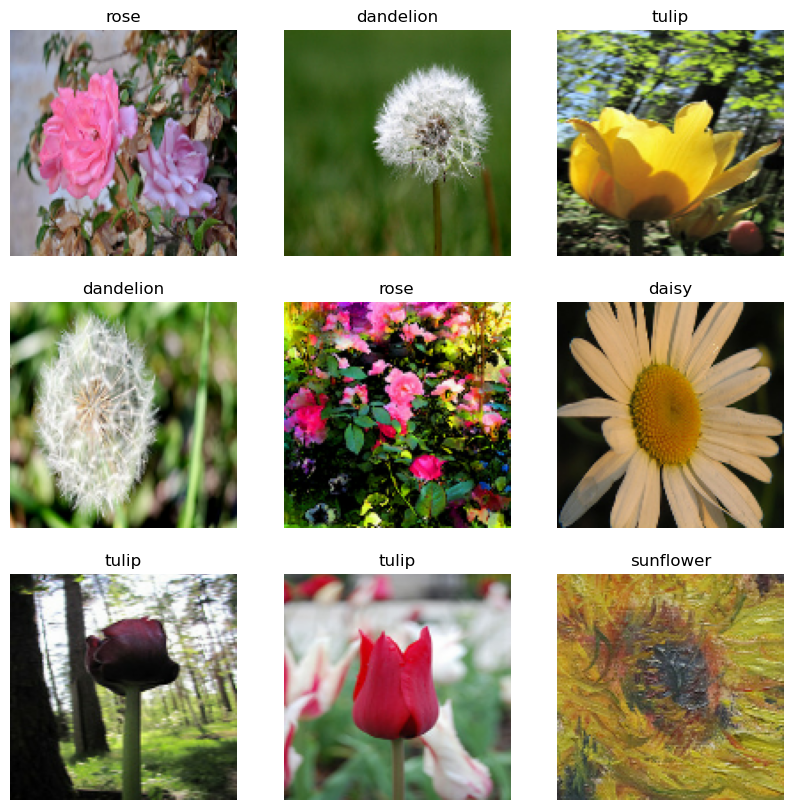

In [6]:
# عرض عينات من الصور
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flower_names[labels[i]])
        plt.axis("off")

In [114]:
# البيانات المكبرة
data_augmentation = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [116]:
cnn_model_1 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),   #DOWNSAMPLING بقلل الابعاد

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(5, activation='softmax')
])
# تجميع النموذج
cnn_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
cnn_model_2 = Sequential([
    data_augmentation,  # تحسين البيانات (Augmentation)
    layers.Rescaling(1./255),  # تطبيع الصور

    # أول طبقة Conv2D و MaxPooling2D
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(),

    # طبقة Conv2D أخرى
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # طبقة Flatten
    layers.Flatten(),
    
    # طبقة Dense
    layers.Dense(128, activation='relu'),
    
    # الطبقة النهائية (تصنيف 5 فئات)
    layers.Dense(5, activation='softmax')
])

# تجميع النموذج
cnn_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [60]:
# استخدام MobileNetV2
from tensorflow.keras.applications import MobileNetV2

# تحميل نموذج MobileNetV2 المدرب مسبقًا بدون الطبقة العليا (include_top=False)
base_model_mobilenet = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

# تجميد الطبقات المدربة مسبقًا
base_model_mobilenet.trainable = False

# بناء النموذج الجديد باستخدام MobileNetV2
mobilenet_model = Sequential([
    data_augmentation,  # تحسين البيانات (Augmentation)
    layers.Rescaling(1./255),  # تطبيع الصور
    base_model_mobilenet,  # إضافة نموذج MobileNetV2 المدرب مسبقًا
    layers.GlobalAveragePooling2D(),  # التجميع باستخدام التجميع المتوسط
    layers.Dense(128, activation='relu'),  # إضافة طبقة كثيفة
    layers.Dense(5, activation='softmax')  # الطبقة النهائية (تصنيف 5 فئات)
])

# تجميع النموذج
mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [35]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential

base_model_vgg16 = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model_vgg16.trainable = False

vgg16_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential

base_model_resnet = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model_resnet.trainable = False

resnet_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [38]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Sequential

base_model_inception = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model_inception.trainable = False

inception_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model_inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [41]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Sequential

base_model_xception = Xception(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model_xception.trainable = False

xception_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model_xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [118]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model10.keras',monitor='val_loss',save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [54]:
# تدريب اول موديل
cnn_model_1_history = cnn_model_1.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5770 - loss: 1.0465 - val_accuracy: 0.2329 - val_loss: 2.2225 - learning_rate: 5.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.5820 - loss: 1.0218 - val_accuracy: 0.2329 - val_loss: 2.5096 - learning_rate: 5.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6215 - loss: 0.9536 - val_accuracy: 0.2329 - val_loss: 2.3082 - learning_rate: 5.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6181 - loss: 0.9597
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6183 - loss: 0.9596 - val_accuracy: 0.2584 - val_loss: 2.2662 - learning_rate: 5.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.6563 - loss: 0.8936 - val_accuracy: 0.2816 - val_loss: 2.1087 - learning_rate: 2.5000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.6643 - loss:

In [80]:
cnn_model_2_history = cnn_model_2.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.3151 - loss: 2.0996 - val_accuracy: 0.5249 - val_loss: 1.1353
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.5483 - loss: 1.1248 - val_accuracy: 0.5713 - val_loss: 1.0649
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.6101 - loss: 1.0010 - val_accuracy: 0.5863 - val_loss: 1.0519
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.6285 - loss: 0.9745 - val_accuracy: 0.6408 - val_loss: 0.9616
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.6478 - loss: 0.9044 - val_accuracy: 0.6489 - val_loss: 0.9474
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.6600 - loss: 0.8644 - val_accuracy: 0.6489 - val_loss: 0.8940
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.6837 - loss: 0.8400 - val_accuracy: 0.6721 - val_loss: 0.8412
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.7008 - loss: 0.8135 - val_accu

In [92]:
mobilenet_model_history = mobilenet_model.fit(
    train_ds,
    epochs=40,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler], 
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.8098 - loss: 0.5388 - val_accuracy: 0.8482 - val_loss: 0.4855 - learning_rate: 1.2500e-04
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 365s 7s/step - accuracy: 0.8580 - loss: 0.4426 - val_accuracy: 0.8586 - val_loss: 0.4600 - learning_rate: 1.2500e-04
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 395s 7s/step - accuracy: 0.8583 - loss: 0.4127 - val_accuracy: 0.8633 - val_loss: 0.4540 - learning_rate: 1.2500e-04
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 405s 7s/step - accuracy: 0.8688 - loss: 0.4009 - val_accuracy: 0.8633 - val_loss: 0.4457 - learning_rate: 1.2500e-04
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 394s 7s/step - accuracy: 0.8771 - loss: 0.3722 - val_accuracy: 0.8540 - val_loss: 0.4557 - learning_rate: 1.2500e-04
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - accuracy: 0.8761 - loss: 0.3681 - val_accuracy: 0.8644 - val_loss: 0.4382 - learning_rate: 1.2500e-04
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - accuracy: 0.8806 

In [104]:
mobilenet_model.save("mobilenet_flower_512.keras")

In [94]:
vgg16_model_history = vgg16_model.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.4009 - loss: 1.4725 - val_accuracy: 0.6049 - val_loss: 1.0277
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6653 - loss: 0.9548 - val_accuracy: 0.6941 - val_loss: 0.8408
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.6937 - loss: 0.8253 - val_accuracy: 0.7184 - val_loss: 0.7788
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.7358 - loss: 0.7378 - val_accuracy: 0.7451 - val_loss: 0.7331
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7474 - loss: 0.7011 - val_accuracy: 0.7590 - val_loss: 0.6995
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.7577 - loss: 0.6712 - val_accuracy: 0.7532 - val_loss: 0.6918
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7614 - loss: 0.6422 - val_accuracy: 0.7706 - val_loss: 0.6752
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.7886 - loss: 0.6138 - val_accuracy: 0.7868 - v

In [93]:
resnet_model_history = resnet_model.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.2851 - loss: 1.5917 - val_accuracy: 0.3105 - val_loss: 1.5225
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3462 - loss: 1.5287 - val_accuracy: 0.3627 - val_loss: 1.5043
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3558 - loss: 1.4887 - val_accuracy: 0.3244 - val_loss: 1.5030
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3728 - loss: 1.4808 - val_accuracy: 0.3546 - val_loss: 1.4993
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3719 - loss: 1.4619 - val_accuracy: 0.3940 - val_loss: 1.4501
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3914 - loss: 1.4364 - val_accuracy: 0.4056 - val_loss: 1.4274
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3854 - loss: 1.4386 - val_accuracy: 0.3963 - val_loss: 1.4142
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3994 - loss: 1.4218 - val_accuracy: 0.4171 - val_loss:

In [45]:
inception_model_history = inception_model.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.4866 - loss: 1.8687

54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.4887 - loss: 1.8567 - val_accuracy: 0.7370 - val_loss: 0.7242
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7254 - loss: 0.7120

54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 668ms/step - accuracy: 0.7255 - loss: 0.7117 - val_accuracy: 0.7509 - val_loss: 0.6842
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 628ms/step - accuracy: 0.7868 - loss: 0.5915 - val_accuracy: 0.7532 - val_loss: 0.6902
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7774 - loss: 0.6044

54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - accuracy: 0.7774 - loss: 0.6043 - val_accuracy: 0.7740 - val_loss: 0.6483
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7900 - loss: 0.5773

54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - accuracy: 0.7901 - loss: 0.5769 - val_accuracy: 0.7798 - val_loss: 0.6265
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.8057 - loss: 0.5260 - val_accuracy: 0.7937 - val_loss: 0.6285
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8219 - loss: 0.4959

54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 644ms/step - accuracy: 0.8218 - loss: 0.4961 - val_accuracy: 0.8065 - val_loss: 0.5876
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 690ms/step - accuracy: 0.8193 - loss: 0.5058 - val_accuracy: 0.7833 - val_loss: 0.6358
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.8273 - loss: 0.4963 - val_accuracy: 0.8111 - val_loss: 0.5907
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8337 - loss: 0.4456

54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.8337 - loss: 0.4458 - val_accuracy: 0.8076 - val_loss: 0.5721
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.8399 - loss: 0.4396 - val_accuracy: 0.8007 - val_loss: 0.6054
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step - accuracy: 0.8255 - loss: 0.4810 - val_accuracy: 0.8007 - val_loss: 0.6183
Epoch 13/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.8530 - loss: 0.4260 - val_accuracy: 0.7845 - val_loss: 0.6053
Epoch 14/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.8411 - loss: 0.4318 - val_accuracy: 0.8076 - val_loss: 0.5881
Epoch 15/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.8514 - loss: 0.4109 - val_accuracy: 0.7822 - val_loss: 0.6433


In [47]:
xception_model_history = xception_model.fit(
    train_ds,
    epochs=15,  
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6009 - loss: 1.0014 - val_accuracy: 0.7683 - val_loss: 0.6475
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7954 - loss: 0.5741 - val_accuracy: 0.8053 - val_loss: 0.5782
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8350 - loss: 0.4931 - val_accuracy: 0.7984 - val_loss: 0.5821
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8436 - loss: 0.4413 - val_accuracy: 0.7937 - val_loss: 0.5767
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8661 - loss: 0.4102

54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8659 - loss: 0.4102 - val_accuracy: 0.8239 - val_loss: 0.5651
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8677 - loss: 0.3947

54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8676 - loss: 0.3945 - val_accuracy: 0.8192 - val_loss: 0.5438
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8769 - loss: 0.3594

54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8769 - loss: 0.3592 - val_accuracy: 0.8204 - val_loss: 0.5395
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8905 - loss: 0.3346 - val_accuracy: 0.8216 - val_loss: 0.5800
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8824 - loss: 0.3338 - val_accuracy: 0.8227 - val_loss: 0.5561
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9043 - loss: 0.2870 - val_accuracy: 0.8192 - val_loss: 0.5839
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8987 - loss: 0.2792 - val_accuracy: 0.8239 - val_loss: 0.5450
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9101 - loss: 0.2579 - val_accuracy: 0.8331 - val_loss: 0.5812


In [80]:
def plot_history(history, model_name):
    # رسم دالة الخسارة (Loss)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # رسم دالة الدقة (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

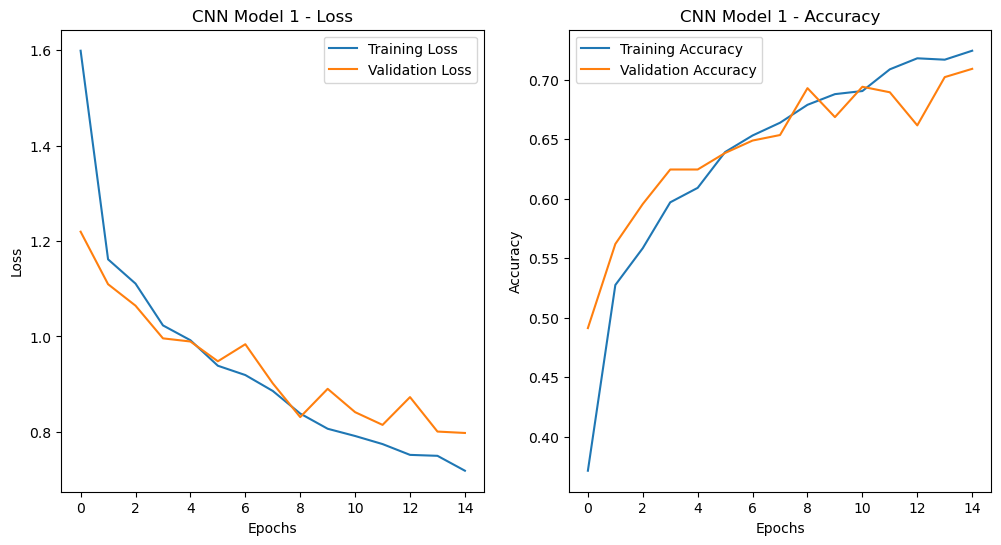

In [85]:
plot_history(cnn_model_1_history, 'CNN Model 1')

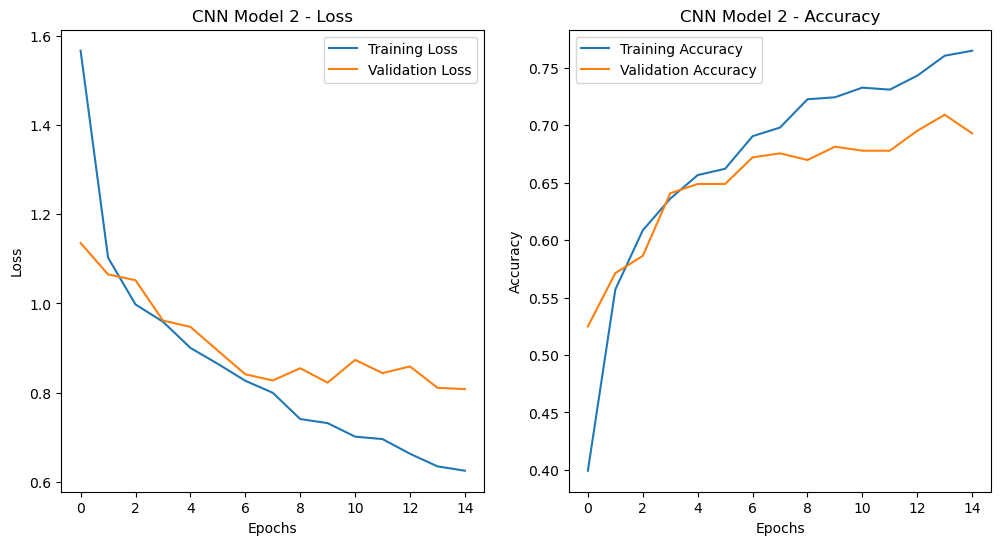

In [87]:
plot_history(cnn_model_2_history, 'CNN Model 2')

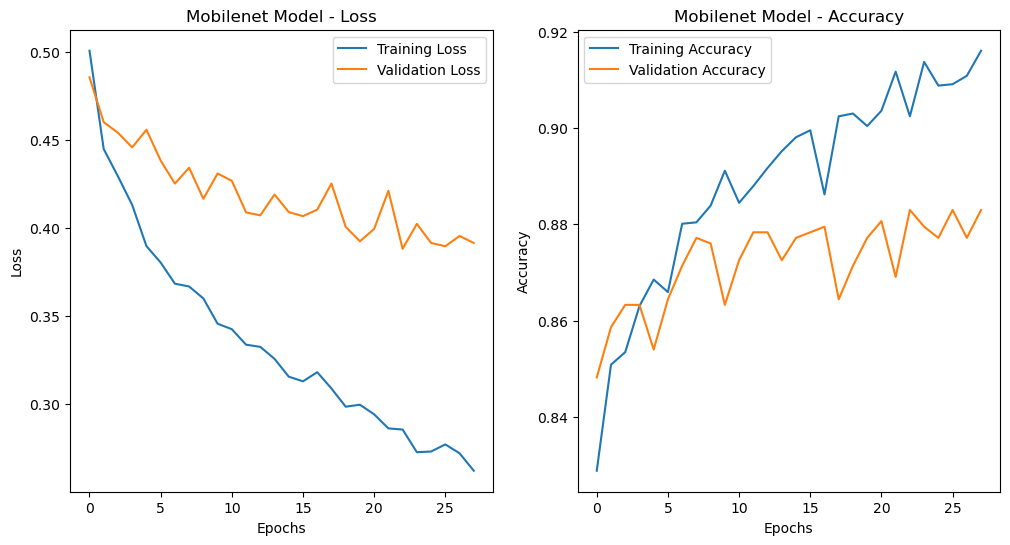

In [96]:
plot_history(mobilenet_model_history, 'Mobilenet Model')

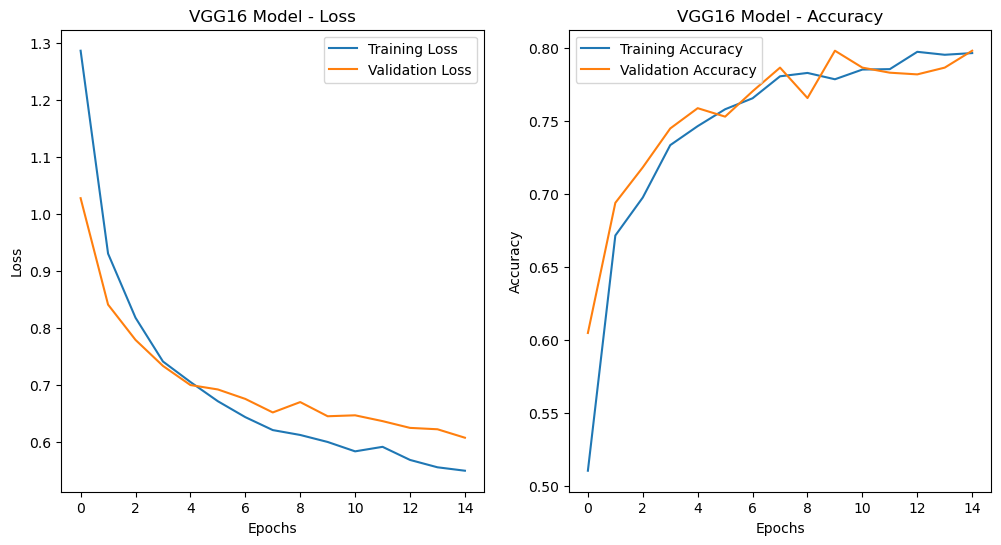

In [97]:
plot_history(vgg16_model_history, 'VGG16 Model')

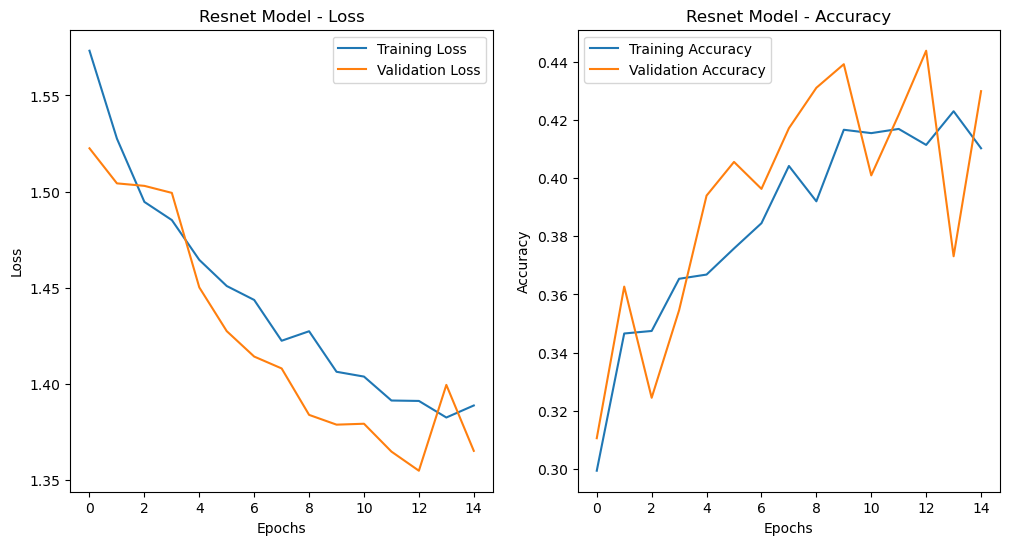

In [99]:
plot_history(resnet_model_history, 'Resnet Model')

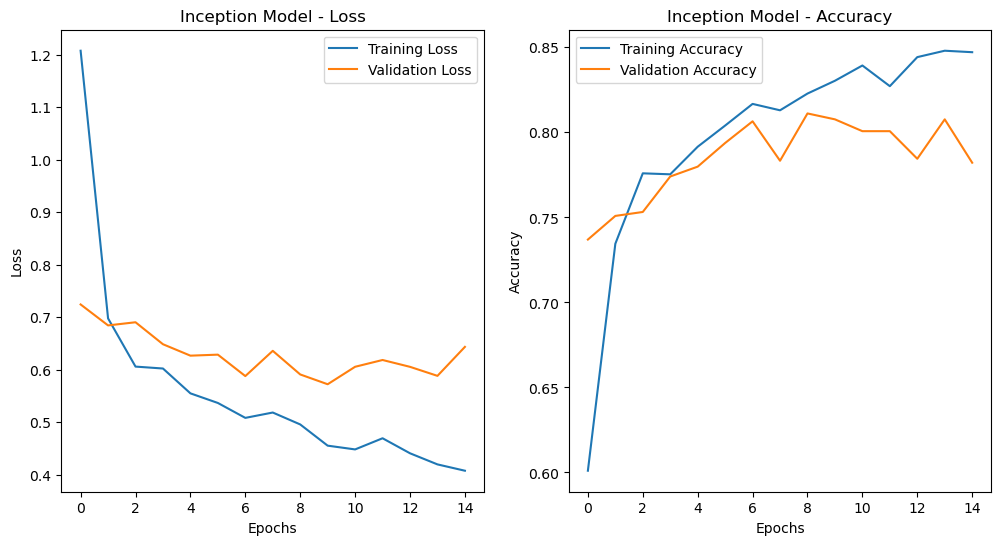

In [61]:
plot_history(inception_model_history, 'Inception Model')

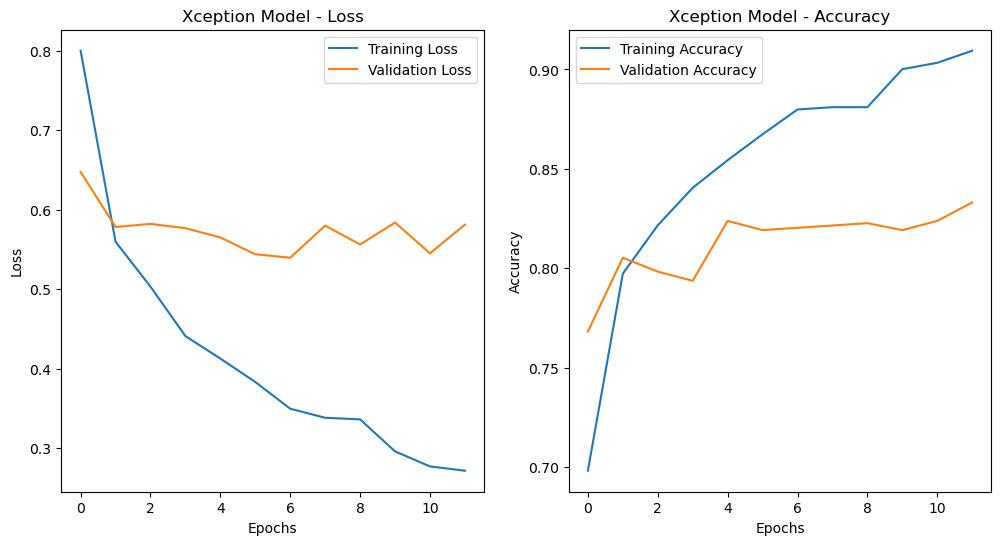

In [63]:
plot_history(xception_model_history, 'Xception Model')

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.19      0.21      0.20       143
   dandelion       0.27      0.20      0.23       200
        rose       0.20      0.16      0.18       159
   sunflower       0.19      0.24      0.21       148
       tulip       0.29      0.31      0.29       213

    accuracy                           0.23       863
   macro avg       0.23      0.23      0.22       863
weighted avg       0.23      0.23      0.23       863



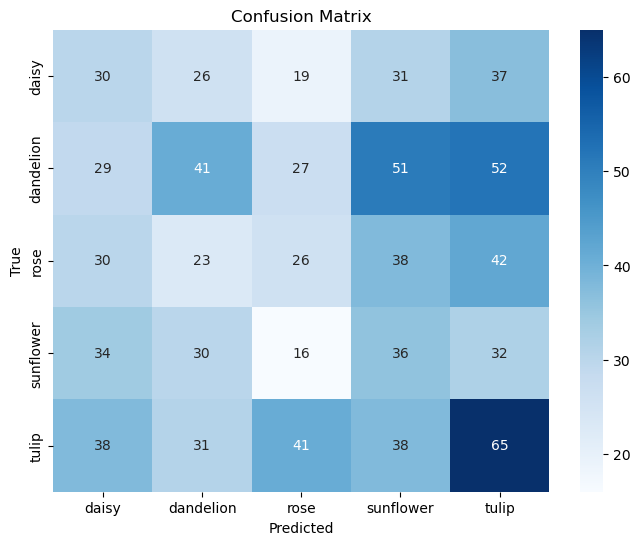

In [101]:
# الحصول على توقعات الموديل
y_pred = cnn_model_1.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.19      0.19      0.19       143
   dandelion       0.21      0.20      0.20       200
        rose       0.24      0.22      0.23       159
   sunflower       0.17      0.24      0.20       148
       tulip       0.25      0.22      0.23       213

    accuracy                           0.21       863
   macro avg       0.21      0.21      0.21       863
weighted avg       0.22      0.21      0.21       863



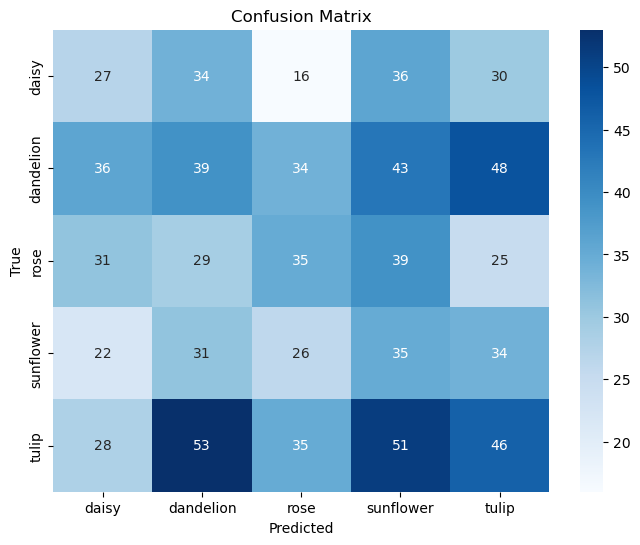

In [103]:
# الحصول على توقعات الموديل
y_pred = cnn_model_2.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.18      0.18      0.18       142
   dandelion       0.28      0.27      0.27       201
        rose       0.24      0.26      0.25       158
   sunflower       0.22      0.24      0.23       149
       tulip       0.26      0.23      0.24       213

    accuracy                           0.24       863
   macro avg       0.24      0.24      0.24       863
weighted avg       0.24      0.24      0.24       863



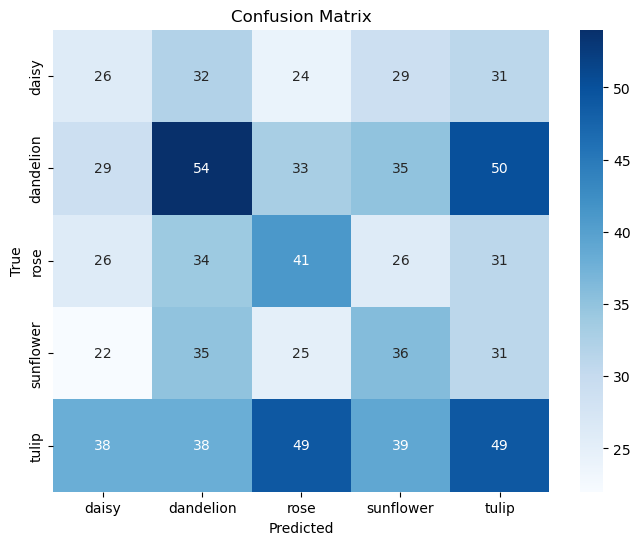

In [98]:
# الحصول على توقعات الموديل
y_pred = mobilenet_model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.17      0.17      0.17       143
   dandelion       0.23      0.21      0.22       200
        rose       0.21      0.19      0.20       159
   sunflower       0.19      0.21      0.20       148
       tulip       0.24      0.25      0.25       213

    accuracy                           0.21       863
   macro avg       0.21      0.21      0.21       863
weighted avg       0.21      0.21      0.21       863



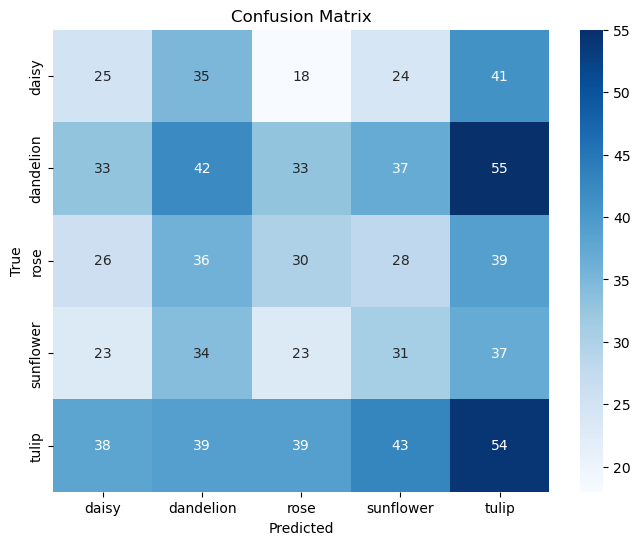

In [107]:
# الحصول على توقعات الموديل
y_pred = vgg16_model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 939ms/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.17      0.17      0.17       143
   dandelion       0.20      0.27      0.23       200
        rose       0.13      0.19      0.16       159
   sunflower       0.22      0.09      0.13       148
       tulip       0.25      0.17      0.20       213

    accuracy                           0.19       863
   macro avg       0.19      0.18      0.18       863
weighted avg       0.20      0.19      0.18       863



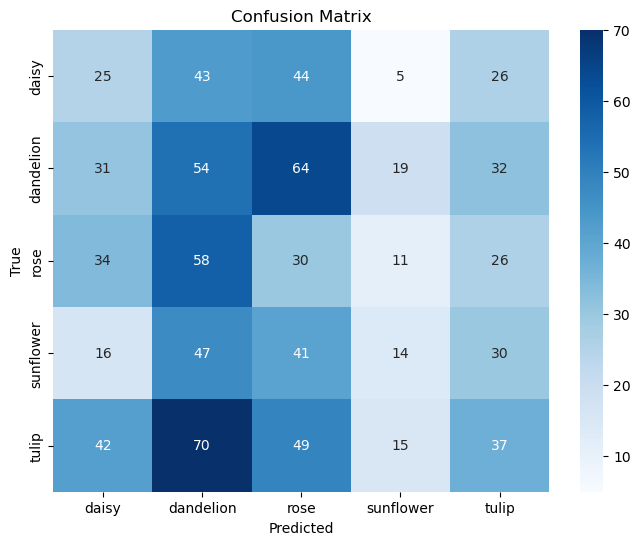

In [109]:
# الحصول على توقعات الموديل
y_pred = resnet_model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 435ms/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.18      0.17      0.17       143
   dandelion       0.26      0.27      0.26       200
        rose       0.17      0.19      0.18       159
   sunflower       0.19      0.19      0.19       148
       tulip       0.23      0.22      0.23       213

    accuracy                           0.21       863
   macro avg       0.21      0.21      0.21       863
weighted avg       0.21      0.21      0.21       863



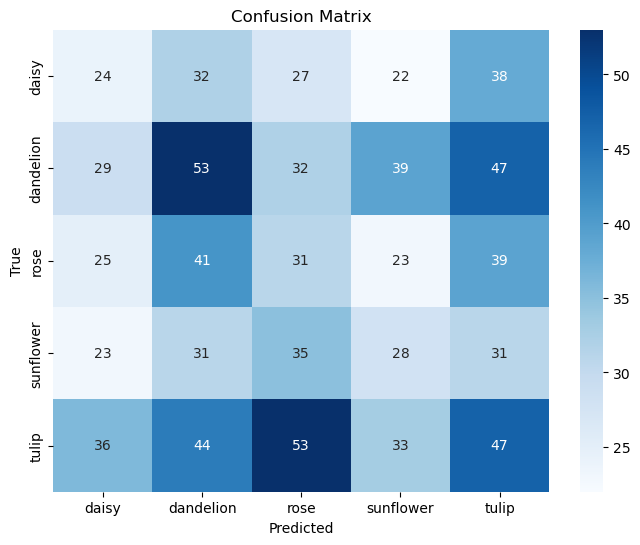

In [110]:
# الحصول على توقعات الموديل
y_pred = inception_model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:

              precision    recall  f1-score   support

       daisy       0.13      0.13      0.13       143
   dandelion       0.24      0.24      0.24       200
        rose       0.17      0.18      0.18       159
   sunflower       0.17      0.17      0.17       148
       tulip       0.27      0.27      0.27       213

    accuracy                           0.21       863
   macro avg       0.20      0.20      0.20       863
weighted avg       0.21      0.21      0.21       863



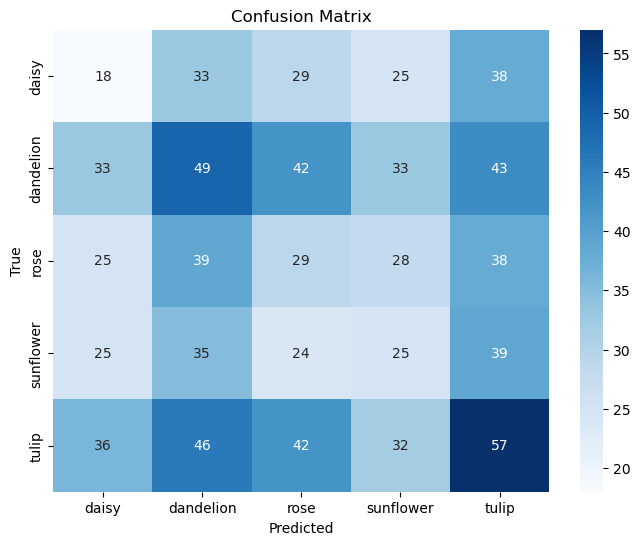

In [111]:
# الحصول على توقعات الموديل
y_pred = xception_model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# الحصول على الـ true labels من val_ds
y_true = np.concatenate([labels.numpy() for _, labels in val_ds])

# طباعة classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=flower_names))

# رسم Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=flower_names, yticklabels=flower_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


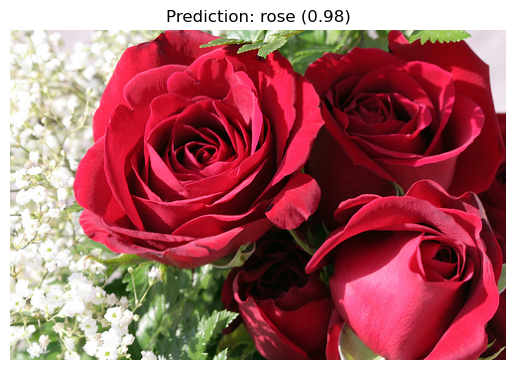

('rose', 0.9776424)

In [102]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # batch dimension
    img_array = img_array / 255.0
    return img_array

def predict_image(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array) 
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    # عرض الصورة والتوقع داخل الدالة
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    return predicted_class, confidence

predict_image(mobilenet_model, 'flowers/rose/568715474_bdb64ccc32.jpg', ['daisy','dandelion','rose','sunflower','tulip'])
